In [1]:
import pandas as pd
pd.options.display.max_columns = 70
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, roc_auc_score, log_loss
from sklearn.utils.class_weight import compute_class_weight


In [2]:
df = pd.read_csv('inc_points_2.csv')

In [3]:
df_1 = pd.read_csv('rich_tracks_2.csv')
df_2 = pd.read_csv('os.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3791240 entries, 0 to 3791239
Data columns (total 12 columns):
IncomingTrackId          int64
Speed                    float64
Latitude                 float64
Longitude                float64
PointDate                object
Height                   float64
Acceleration             float64
Deceleration             float64
TickTimestamp            int64
AccelerationXOriginal    float64
AccelerationYOriginal    float64
AccelerationZOriginal    float64
dtypes: float64(9), int64(2), object(1)
memory usage: 347.1+ MB


In [5]:
df['PointDate'] = pd.to_datetime(df['PointDate'], utc=True)

# Подтянем к rich_tracks_2 из os вид устройста и после из rich_tracks_2 подтянем вид устройства в inc_points_2

In [48]:
df1_new = df_1.join(df_2.set_index('DeviceToken'), on='DeviceToken')
df_new = df.join(df1_new.loc[:,['IncomingTrackId','os_version','TrackOrigin']].set_index('IncomingTrackId'), on='IncomingTrackId')

In [7]:
df_new[df_new['os_version'] == 'iOS'][:2]

,IncomingTrackId,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal,os_version,TrackOrigin
0,20702795,0.0,55.863077,52.227935,2019-10-17 12:35:23+00:00,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434,iOS,OriginalDriver
1,20702795,0.0,55.863077,52.227935,2019-10-17 12:35:23+00:00,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091,iOS,OriginalDriver


In [8]:
df_new[df_new['os_version'] == 'Android'][:2]

,IncomingTrackId,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal,os_version,TrackOrigin
808,20691750,14.623364,55.171671,61.373645,2019-10-17 12:35:29+00:00,206800.0,0.793684,7.786039,1571333728,1.016339,8.920795,3.934870,Android,OriginalDriver
809,20691750,14.414804,55.171687,61.373590,2019-10-17 12:35:30+00:00,206800.0,0.790284,7.752688,1571333729,1.268927,8.682572,4.011485,Android,OriginalDriver


# Прорисуем гистограммы данных для того, чтобы вычленить столбцы с отклонениями в распределениях для различных операционных систем

In [9]:
df_new.columns

Index(['IncomingTrackId', 'Speed', 'Latitude', 'Longitude', 'PointDate',
       'Height', 'Acceleration', 'Deceleration', 'TickTimestamp',
       'AccelerationXOriginal', 'AccelerationYOriginal',
       'AccelerationZOriginal', 'os_version', 'TrackOrigin'],
      dtype='object')

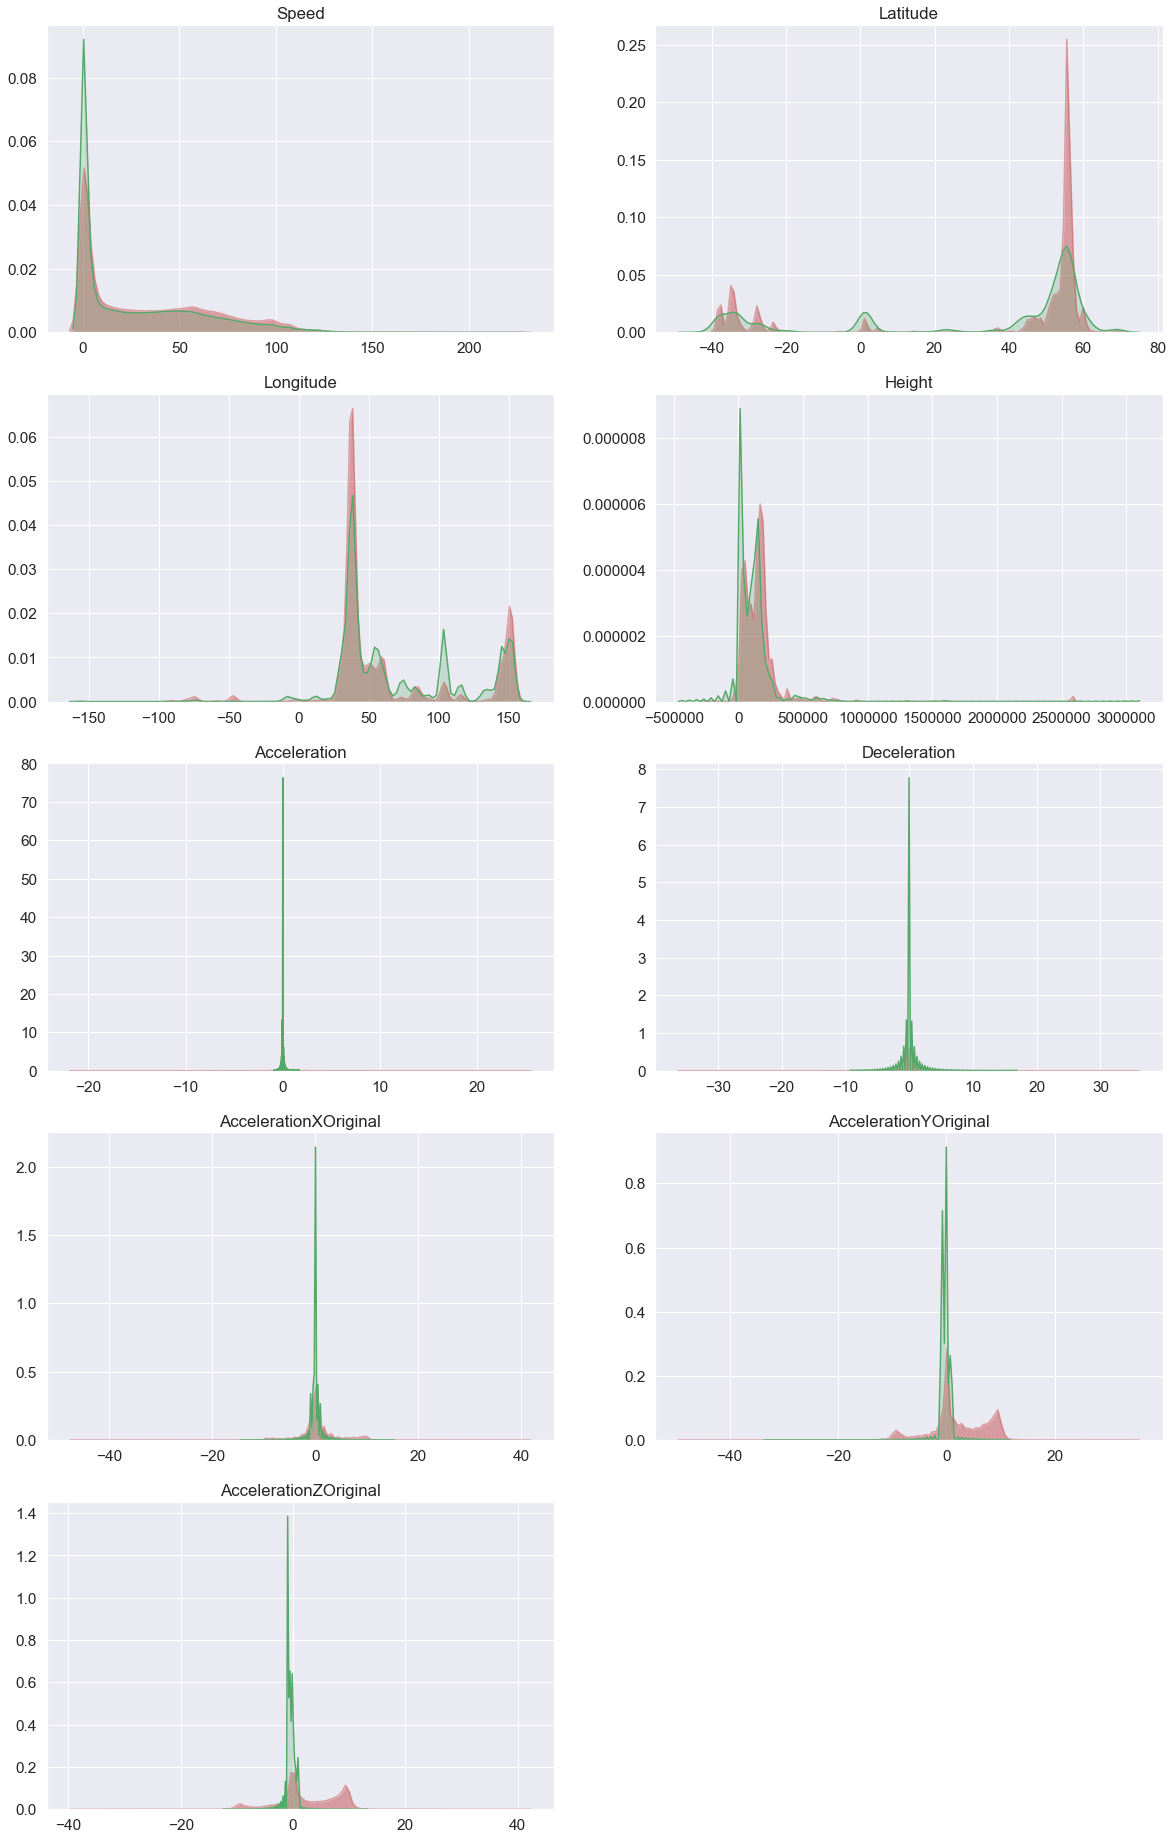

In [10]:
list_col = ['Speed','Latitude', 'Longitude', 'Height','Acceleration', 'Deceleration','AccelerationXOriginal',\
            'AccelerationYOriginal', 'AccelerationZOriginal']
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))

for i, colname in enumerate(list_col):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.kdeplot(df_new.loc[df_new['os_version'] == 'Android', colname].dropna(), shade=True, alpha=0.5, legend=False, color='r')
    sns.kdeplot(df_new.loc[df_new['os_version'] == 'iOS', colname].dropna(), shade=True, legend=False, color='g')
    
plt.show()

# Рассмотрим Acceleration, Deceleration. На гистограммах явное различие для данных с разных систем

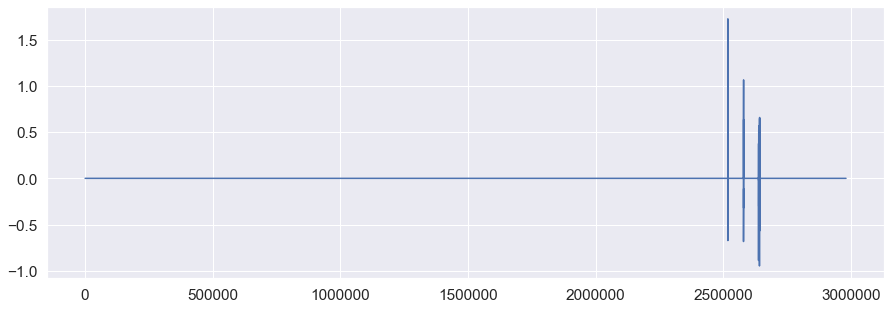

In [11]:
plt.figure(figsize = (15,5))
plt.plot(df_new[df_new['os_version'] == 'iOS'].reset_index().index,df_new[df_new['os_version'] == 'iOS'][['Acceleration']])

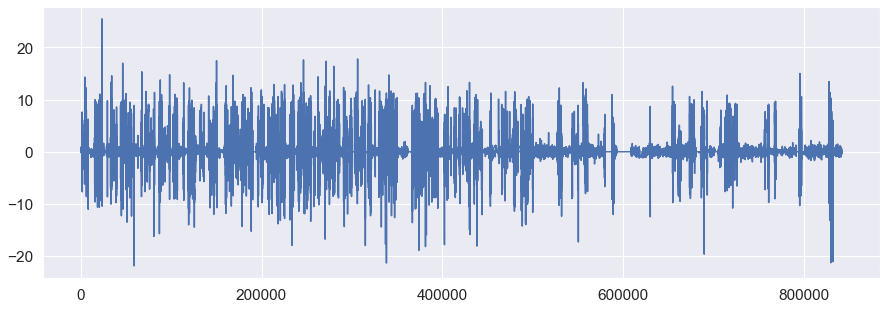

In [12]:
plt.figure(figsize = (15,5))
plt.plot(df_new[df_new['os_version'] == 'Android'].reset_index().index,df_new[df_new['os_version'] == 'Android'][['Acceleration']])

In [13]:
iOS_Acc = np.unique(df_new[(df_new['os_version'] == 'iOS')&(df_new['Acceleration'] != 0)]['IncomingTrackId'].values).shape[0]
android_Acc = np.unique(df_new[(df_new['os_version'] == 'Android')&(df_new['Acceleration'] != 0)]['IncomingTrackId'].values).shape[0]
print(f'число уникальных IncomingTrackId в устройствах iOS для Acceleration : {iOS_Acc}')
print(f'число уникальных IncomingTrackId в устройствах Android для Acceleration : {android_Acc}')

число уникальных IncomingTrackId в устройствах iOS для Acceleration : 4
число уникальных IncomingTrackId в устройствах Android для Acceleration : 841


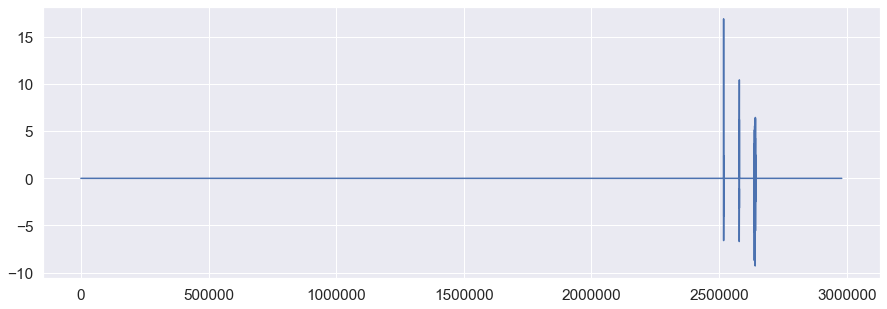

In [14]:
plt.figure(figsize = (15,5))
plt.plot(df_new[df_new['os_version'] == 'iOS'].reset_index().index,df_new[df_new['os_version'] == 'iOS'][['Deceleration']])

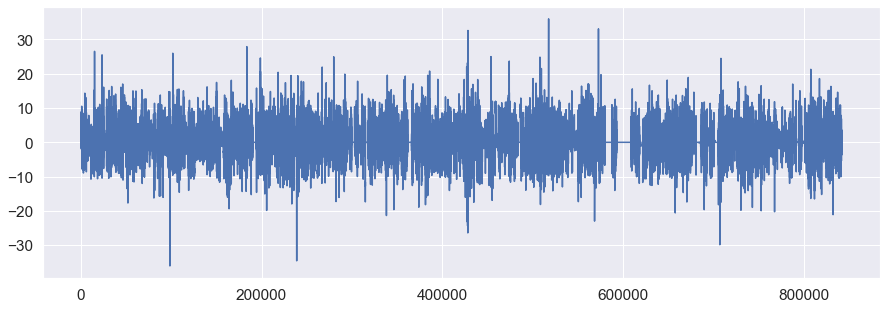

In [15]:
plt.figure(figsize = (15,5))
plt.plot(df_new[df_new['os_version'] == 'Android'].reset_index().index,df_new[df_new['os_version'] == 'Android'][['Deceleration']])

In [16]:
iOS_Dec = np.unique(df_new[(df_new['os_version'] == 'iOS')&(df_new['Deceleration'] != 0)]['IncomingTrackId'].values).shape[0]
android_Dec = np.unique(df_new[(df_new['os_version'] == 'Android')&(df_new['Deceleration'] != 0)]['IncomingTrackId'].values).shape[0]
print(f'число уникальных IncomingTrackId в устройствах iOS для Deceleration : {iOS_Dec}')
print(f'число уникальных IncomingTrackId в устройствах Android для Deceleration : {android_Dec}')

число уникальных IncomingTrackId в устройствах iOS для Deceleration : 4
число уникальных IncomingTrackId в устройствах Android для Deceleration : 841


In [17]:
ios_notnull = df_new[(df_new['os_version'] == 'iOS')&(df_new['Deceleration'] != 0)]['IncomingTrackId'].unique()
df_2[df_2['DeviceToken'].isin(df_1[df_1['IncomingTrackId'].isin(ios_notnull)]['DeviceToken'])]

,DeviceToken,os_version
892,D525DD98-9308-4D5A-8398-15537783E9C4,Android
1617,D525DD98-9308-4D5A-8398-15537783E9C4,iOS


# Данные по этим двум показателям с устройств на системах iOS не поступали. Единственные отличные от нуля данные поступали с устройства, которому присвоены два вида 'os_version' . Восстановить показатели посредством представленного набора данных проблематично. 

# Рассмотрим 'AccelerationXOriginal', 'AccelerationYOriginal', 'AccelerationZOriginal' у них также разительно отличаются распределения, в частности диапазон данных

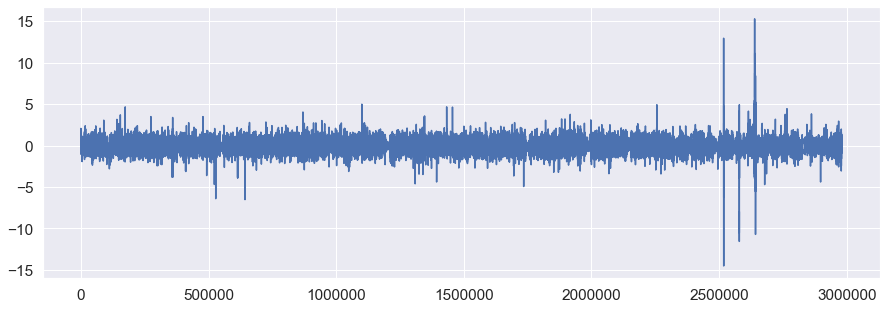

In [18]:
plt.figure(figsize = (15,5))
plt.plot(df_new[df_new['os_version'] == 'iOS'].reset_index().index,df_new[df_new['os_version'] == 'iOS']\
         [['AccelerationXOriginal']])

In [19]:
ios_ext = df_new[(df_new['os_version'] == 'iOS')&((df_new['AccelerationXOriginal'] > 8)|(df_new['AccelerationXOriginal'] < -8))]['IncomingTrackId'].unique()
df_2[df_2['DeviceToken'].isin(df_1[df_1['IncomingTrackId'].isin(ios_ext)]['DeviceToken'])]

,DeviceToken,os_version
892,D525DD98-9308-4D5A-8398-15537783E9C4,Android
1617,D525DD98-9308-4D5A-8398-15537783E9C4,iOS


# Как видно экстремумы также принадлежат трекам с задвоенной системой, выбрасываем их из рассматрения

Text(0.5, 1.0, 'AccelerationXOriginal with Android')

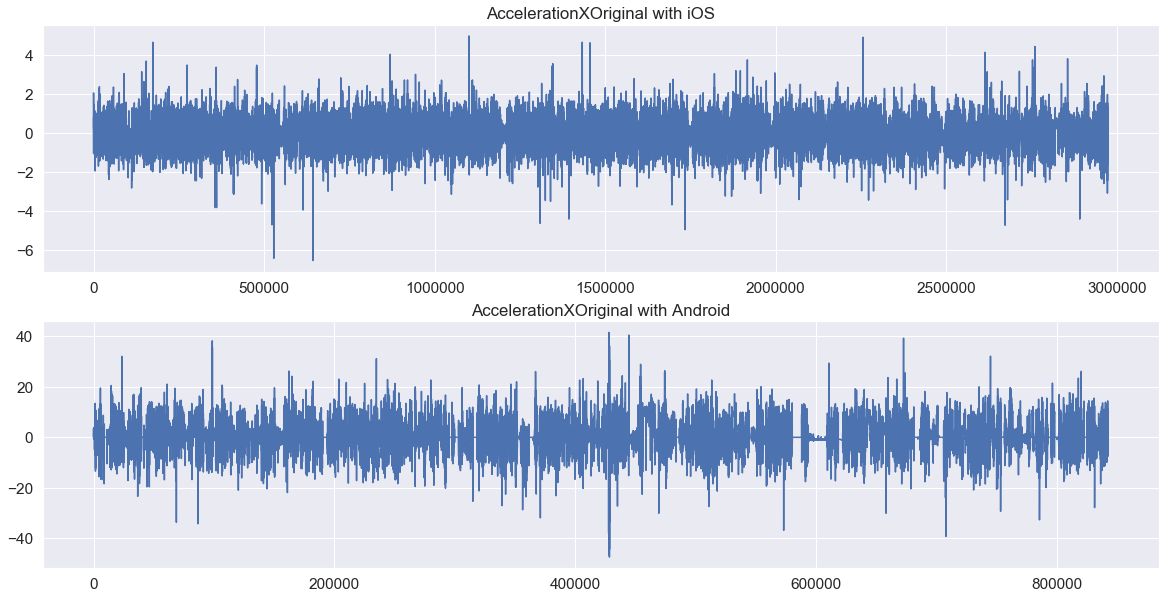

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
ax1.plot(df_new[(df_new['os_version'] == 'iOS')&(~df_new['IncomingTrackId'].isin(ios_ext))].reset_index().index,\
         df_new[(df_new['os_version'] == 'iOS')&(~df_new['IncomingTrackId'].isin(ios_ext))][['AccelerationXOriginal']])
ax1.set_title('AccelerationXOriginal with iOS')
ax2.plot(df_new[df_new['os_version'] == 'Android'].reset_index().index,df_new[df_new['os_version'] == 'Android']\
         [['AccelerationXOriginal']])
ax2.set_title('AccelerationXOriginal with Android')

<function matplotlib.pyplot.show(*args, **kw)>

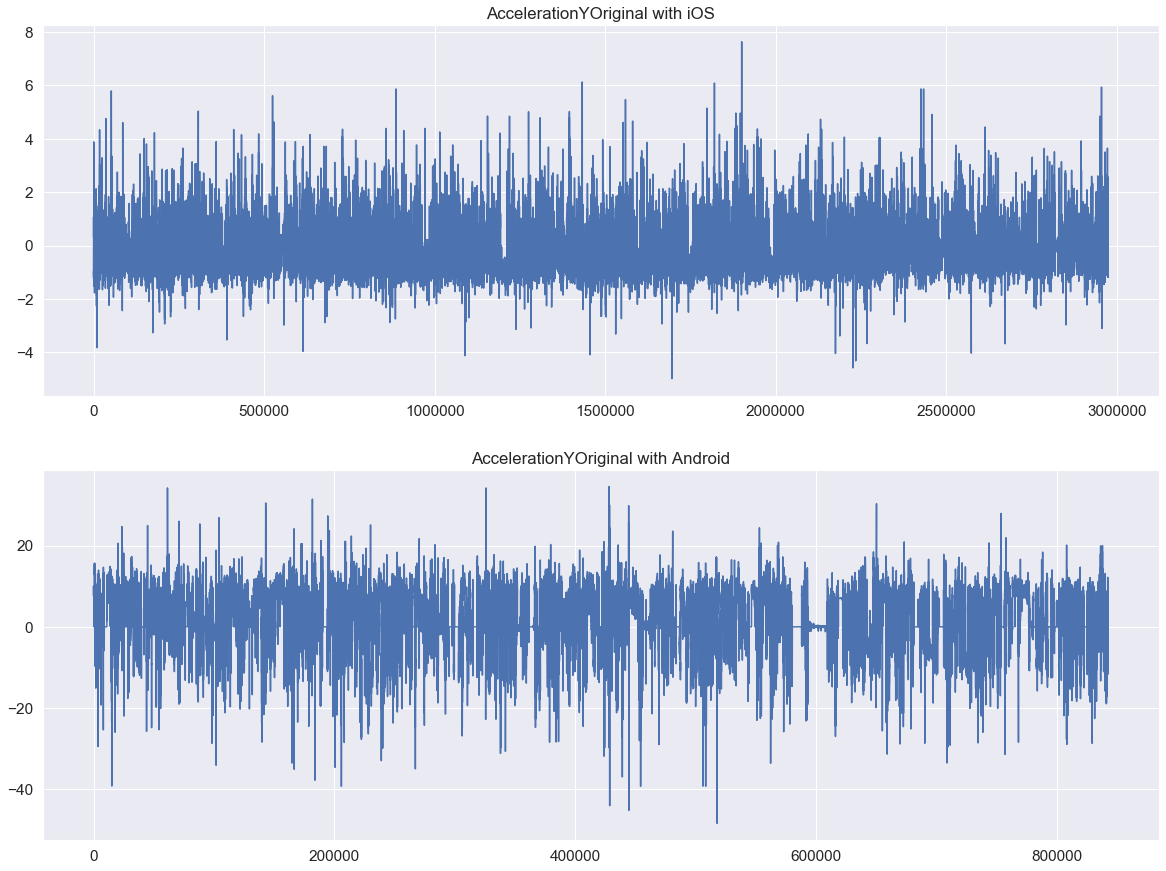

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
ax1.plot(df_new[(df_new['os_version'] == 'iOS')&(~df_new['IncomingTrackId'].isin(ios_ext))].reset_index().index,\
         df_new[(df_new['os_version'] == 'iOS')&(~df_new['IncomingTrackId'].isin(ios_ext))][['AccelerationYOriginal']])
ax1.set_title('AccelerationYOriginal with iOS')
ax2.plot(df_new[df_new['os_version'] == 'Android'].reset_index().index,df_new[df_new['os_version'] == 'Android']\
         [['AccelerationYOriginal']])
ax2.set_title('AccelerationYOriginal with Android')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

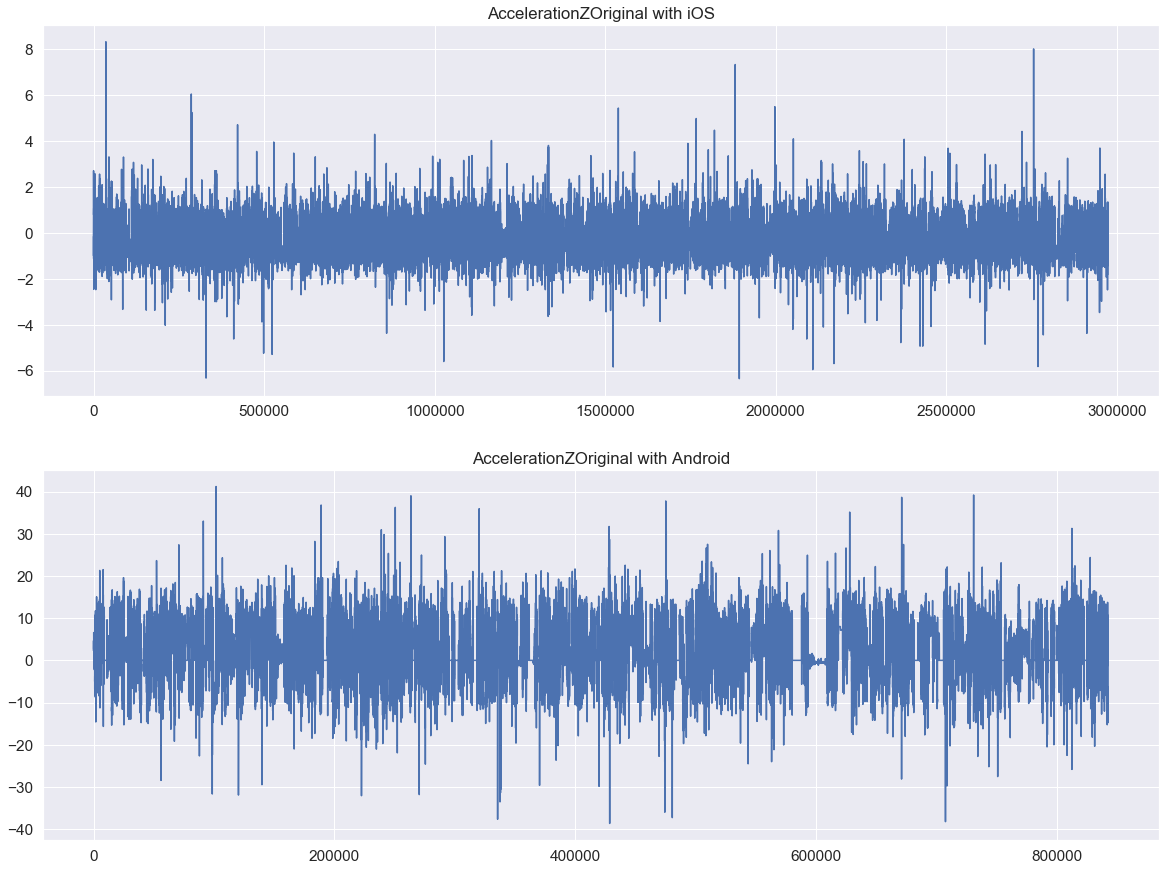

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
ax1.plot(df_new[(df_new['os_version'] == 'iOS')&(~df_new['IncomingTrackId'].isin(ios_ext))].reset_index().index,\
         df_new[(df_new['os_version'] == 'iOS')&(~df_new['IncomingTrackId'].isin(ios_ext))][['AccelerationZOriginal']])
ax1.set_title('AccelerationZOriginal with iOS')
ax2.plot(df_new[df_new['os_version'] == 'Android'].reset_index().index,df_new[df_new['os_version'] == 'Android']\
         [['AccelerationZOriginal']])
ax2.set_title('AccelerationZOriginal with Android')
plt.show

# Можно утверждать, что именно эти данные имеют разный масштаб. Для приведения их к одному масштабу сдантартизируем их:

In [23]:
list_transform = ['AccelerationXOriginal', 'AccelerationYOriginal', 'AccelerationZOriginal']
for transform in list_transform:
    for os in ['iOS','Android']:
        st = StandardScaler()        
        st.fit(df_new[df_new['os_version'] == os][[transform]])
        df_new.loc[df_new['os_version'] == os,transform] = st.transform(df_new[df_new['os_version'] == os][[transform]])


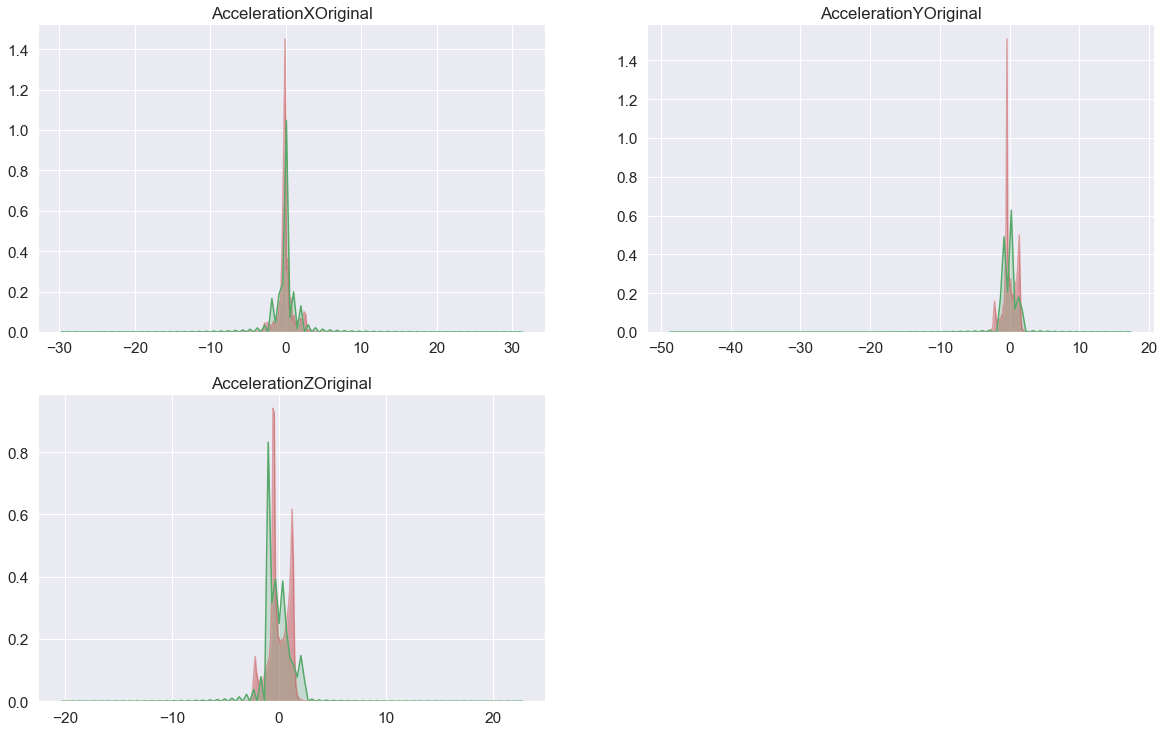

In [24]:
list_col = ['AccelerationXOriginal','AccelerationYOriginal', 'AccelerationZOriginal']
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))
for i, colname in enumerate(list_col):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.kdeplot(df_new.loc[df_new['os_version'] == 'Android', colname].dropna(), shade=True, alpha=0.5, legend=False, color='r')
    sns.kdeplot(df_new.loc[df_new['os_version'] == 'iOS', colname].dropna(), shade=True, legend=False, color='g')
    
plt.show()

In [25]:
df_new['TrackOrigin'].value_counts(normalize=True)

OriginalDriver    0.723797
Passanger         0.241619
Taxi              0.034584
Name: TrackOrigin, dtype: float64

In [26]:
df_new['os_version'].value_counts(normalize=True)

iOS        0.779647
Android    0.220353
Name: os_version, dtype: float64

In [27]:
df_new.describe()

,IncomingTrackId,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
count,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06
mean,2.069676e+07,2.805110e+01,3.205446e+01,7.034660e+01,1.257628e+05,5.859348e-02,1.145132e-01,1.571306e+09,1.293197e-14,-7.857606e-15,-1.010061e-14
std,2.340588e+05,3.251927e+01,3.588891e+01,4.571365e+01,1.561878e+05,7.221290e-01,1.111087e+00,1.593098e+05,1.000000e+00,1.000000e+00,1.000000e+00
min,1.988839e+07,0.000000e+00,-4.315735e+01,-1.563825e+02,-4.500000e+05,-2.189765e+01,-3.603381e+01,1.570343e+09,-2.966825e+01,-4.855064e+01,-2.018844e+01
25%,2.066303e+07,8.261786e-02,1.352203e+00,3.762927e+01,3.383600e+04,0.000000e+00,0.000000e+00,1.571302e+09,-3.307160e-01,-6.972409e-01,-8.089140e-01
50%,2.068272e+07,1.304783e+01,5.267011e+01,5.002772e+01,1.097650e+05,0.000000e+00,0.000000e+00,1.571310e+09,-1.003536e-02,-3.281461e-02,-1.964112e-01
75%,2.071867e+07,5.109833e+01,5.576547e+01,1.038622e+02,1.639000e+05,0.000000e+00,0.000000e+00,1.571317e+09,2.971574e-01,5.481254e-01,6.544498e-01
max,2.151483e+07,2.251463e+02,6.949774e+01,1.586358e+02,3.087814e+06,2.549077e+01,3.598226e+01,1.571850e+09,3.129092e+01,1.726605e+01,2.257785e+01


In [28]:
df_new['TrackOrigin'] = df_new['TrackOrigin'].apply(lambda x: 0 if x == 'OriginalDriver' else 1)
df_new['os_version'] = df_new['os_version'].apply(lambda x: 0 if x == 'iOS' else 1)
df_new['hours_time'] = df['PointDate'].dt.hour

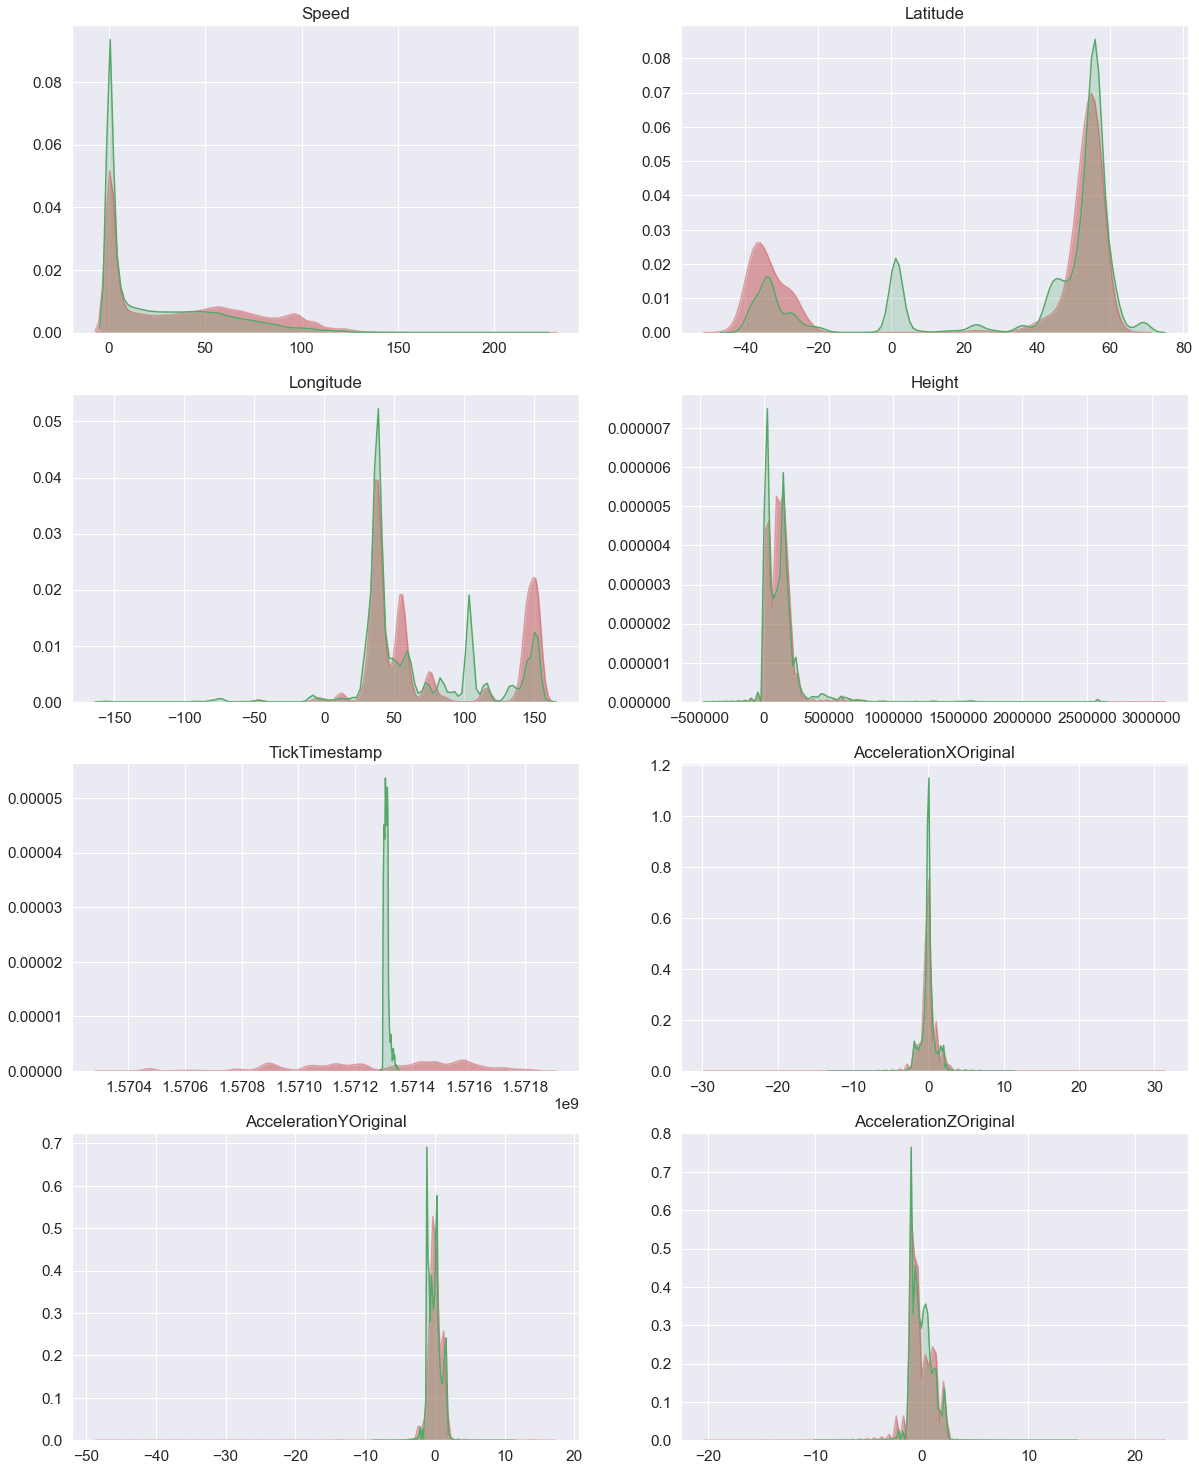

In [29]:
list_col = ['Speed', 'Latitude', 'Longitude', 'Height', 'TickTimestamp', 'AccelerationXOriginal', 'AccelerationYOriginal', 'AccelerationZOriginal']
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))
for i, colname in enumerate(list_col):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.kdeplot(df_new.loc[df_new['TrackOrigin'] == 1, colname].dropna(), shade=True, alpha=0.5, legend=False, color='r')
    sns.kdeplot(df_new.loc[df_new['TrackOrigin'] == 0, colname].dropna(), shade=True, legend=False, color='g')
    
plt.show()

In [30]:
df_mean = df_new.groupby(by=['IncomingTrackId']).mean().reset_index()

In [31]:
#df_mean.columns, , 'TickTimestamp'

In [32]:
list_fich = [ 'IncomingTrackId', 'Speed', 'Latitude', 'Longitude', 'Height', 'TickTimestamp', 'AccelerationXOriginal', 'AccelerationYOriginal', 'AccelerationZOriginal', 'hours_time']

In [33]:
train = df_new.join(df_mean.loc[:,[ 'IncomingTrackId', 'Speed', 'Latitude', 'Longitude', 'Height', 'AccelerationXOriginal',\
                                   'AccelerationYOriginal', 'AccelerationZOriginal', 'hours_time']].set_index('IncomingTrackId'), on='IncomingTrackId', rsuffix='_mean')

In [34]:
train = train.drop(['IncomingTrackId', 'PointDate', 'Acceleration', 'Deceleration', 'TickTimestamp', 'os_version'], axis=1)

In [35]:
target = train.pop('TrackOrigin')

In [36]:
target.value_counts()

0    2766851
1    1055838
Name: TrackOrigin, dtype: int64

In [37]:
weights = compute_class_weight('balanced', np.array([0, 1]), target)

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=.4, stratify=target, random_state=40 )
scl = StandardScaler()


In [39]:

colum = X_train.columns
scl.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:

X_train = pd.DataFrame(scl.transform(X_train),columns=colum)
X_test = scl.transform(X_test)

In [41]:
model_catb = CatBoostClassifier(class_weights=weights, random_state=40, max_depth=4, n_estimators=150, eval_metric='F1')
cv_scores = []
for train_idx, test_idx in skf.split(X_train, y_train):
    cv_train_df, cv_valid_df = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
    y_cv_train, y_cv_valid = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model_catb.fit(cv_train_df, y_cv_train, verbose_eval=1000)
    
    cv_scores.append(f1_score(y_cv_valid, model_catb.predict(cv_valid_df)))
    print(cv_scores)

Learning rate set to 0.5
0:	learn: 0.8354254	total: 1.04s	remaining: 2m 35s
149:	learn: 0.9991091	total: 2m 6s	remaining: 0us
[0.9985285357550031]
Learning rate set to 0.5
0:	learn: 0.8362121	total: 889ms	remaining: 2m 12s
149:	learn: 0.9994399	total: 2m 7s	remaining: 0us
[0.9985285357550031, 0.9993447696036251]
Learning rate set to 0.5
0:	learn: 0.8355184	total: 935ms	remaining: 2m 19s
149:	learn: 0.9996818	total: 2m 11s	remaining: 0us
[0.9985285357550031, 0.9993447696036251, 0.9994594530611923]
Learning rate set to 0.5
0:	learn: 0.8354785	total: 897ms	remaining: 2m 13s
149:	learn: 0.9990845	total: 2m 10s	remaining: 0us
[0.9985285357550031, 0.9993447696036251, 0.9994594530611923, 0.9987291112461814]
Learning rate set to 0.5
0:	learn: 0.8354901	total: 880ms	remaining: 2m 11s
149:	learn: 0.9991449	total: 2m 12s	remaining: 0us
[0.9985285357550031, 0.9993447696036251, 0.9994594530611923, 0.9987291112461814, 0.9986900562644508]


In [42]:
np.mean(cv_scores)

0.9989503851860905

# Визуализируем значимость фичей

In [43]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

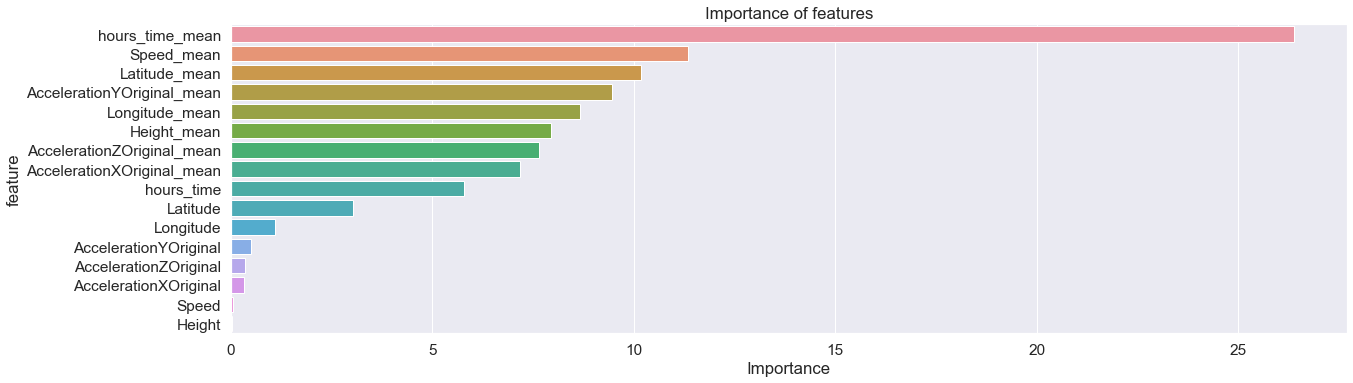

In [44]:
show_feature_importances(X_train.columns, model_catb.feature_importances_)

# Проверим модель на тестовой выборке различными метриками

In [45]:
f1_score(y_test, model_catb.predict(X_test))

0.9986743271618528

In [46]:
roc_auc_score(y_test, model_catb.predict(X_test))

0.9991513789385559

In [47]:
log_loss(y_test, model_catb.predict(X_test))

0.025298906594457053